In [3]:
# Run this if you're using Google Colab
!pip install xgboost pandas scikit-learn seaborn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb
from joblib import Parallel, delayed

In [5]:
# Load the flood dataset
df = pd.read_csv("FloodPrediction.csv")  # Replace path if needed

# Show initial info
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20544 entries, 0 to 20543
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sl                 20544 non-null  int64  
 1   Station_Names      20544 non-null  object 
 2   Year               20544 non-null  int64  
 3   Month              20544 non-null  int64  
 4   Max_Temp           20544 non-null  float64
 5   Min_Temp           20544 non-null  float64
 6   Rainfall           20544 non-null  float64
 7   Relative_Humidity  20544 non-null  float64
 8   Wind_Speed         20544 non-null  float64
 9   Cloud_Coverage     20544 non-null  float64
 10  Bright_Sunshine    20544 non-null  float64
 11  Station_Number     20544 non-null  int64  
 12  X_COR              20544 non-null  float64
 13  Y_COR              20544 non-null  float64
 14  LATITUDE           20544 non-null  float64
 15  LONGITUDE          20544 non-null  float64
 16  ALT                205

,Sl,Station_Names,Year,Month,Max_Temp,Min_Temp,Rainfall,Relative_Humidity,Wind_Speed,Cloud_Coverage,Bright_Sunshine,Station_Number,X_COR,Y_COR,LATITUDE,LONGITUDE,ALT,Period,Flood?
0,0,Barisal,1949,1,29.4,12.3,0.0,68.0,0.453704,0.6,7.831915,41950,536809.8,510151.9,22.7,90.36,4,1949.01,NaN
1,1,Barisal,1949,2,33.9,15.2,9.0,63.0,0.659259,0.9,8.314894,41950,536809.8,510151.9,22.7,90.36,4,1949.02,NaN
2,2,Barisal,1949,3,36.7,20.2,8.0,59.0,1.085185,1.5,8.131915,41950,536809.8,510151.9,22.7,90.36,4,1949.03,NaN
3,3,Barisal,1949,4,33.9,23.9,140.0,71.0,1.772222,3.9,8.219149,41950,536809.8,510151.9,22.7,90.36,4,1949.04,NaN
4,4,Barisal,1949,5,35.6,25.0,217.0,76.0,1.703704,4.1,7.046809,41950,536809.8,510151.9,22.7,90.36,4,1949.05,NaN


In [6]:
# 3. Data Cleaning and Exploration

# Display missing values for each column
missing_info = df.isnull().sum()
print("Missing values:\n{}".format(missing_info))

# Show data types of each column
types_info = df.dtypes
print("\nData types:\n{}".format(types_info))

# Remove rows where the "Flood?" column has missing data
df = df[df["Flood?"].notna()]


Missing values:
Sl                       0
Station_Names            0
Year                     0
Month                    0
Max_Temp                 0
Min_Temp                 0
Rainfall                 0
Relative_Humidity        0
Wind_Speed               0
Cloud_Coverage           0
Bright_Sunshine          0
Station_Number           0
X_COR                    0
Y_COR                    0
LATITUDE                 0
LONGITUDE                0
ALT                      0
Period                   0
Flood?               16051
dtype: int64

Data types:
Sl                     int64
Station_Names         object
Year                   int64
Month                  int64
Max_Temp             float64
Min_Temp             float64
Rainfall             float64
Relative_Humidity    float64
Wind_Speed           float64
Cloud_Coverage       float64
Bright_Sunshine      float64
Station_Number         int64
X_COR                float64
Y_COR                float64
LATITUDE             float64
LONGITUDE 

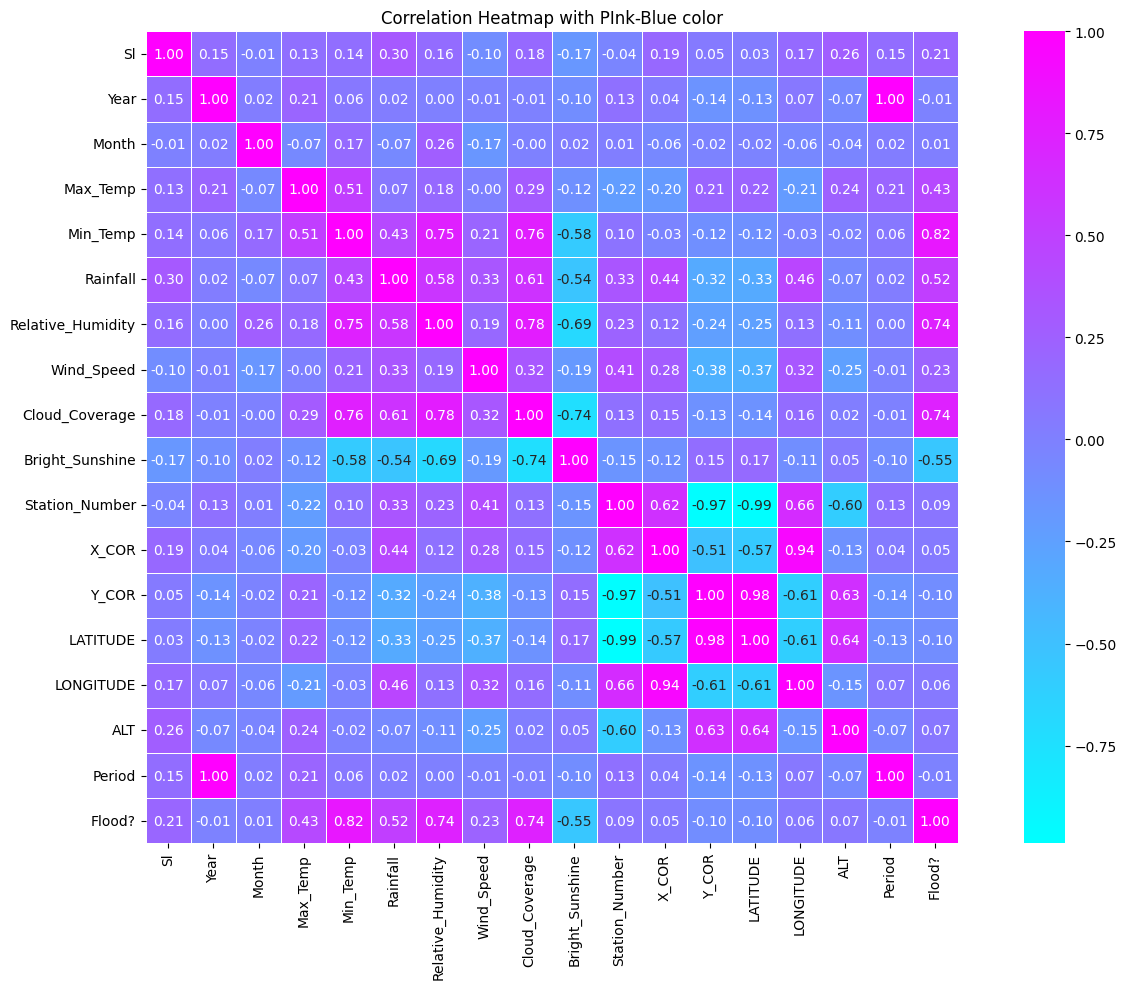

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
fig, ax = plt.subplots(figsize=(14, 10))

# Compute correlation matrix excluding 'Station_Names'
correlation_matrix = df.loc[:, df.columns != 'Station_Names'].corr()

# Draw heatmap with pink-blue style using 'cool' or 'pink' to 'Blues'
sns.heatmap(
    correlation_matrix,
    ax=ax,
    annot=True,
    fmt=".2f",
    cmap="cool",  # pink to blue
    square=True,
    linewidths=0.5
)

# Title and layout
ax.set_title("Correlation Heatmap with PInk-Blue color")
plt.tight_layout()
plt.show()


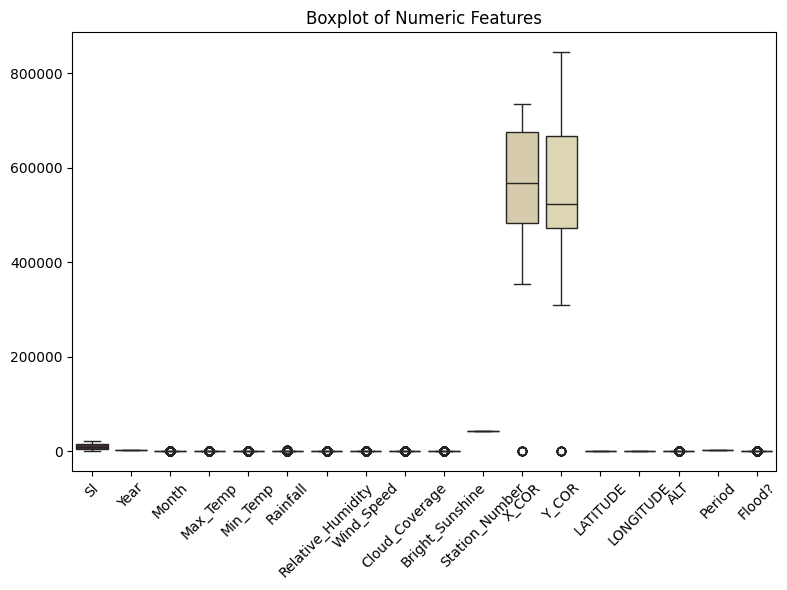

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(data=df.select_dtypes(include=['float64', 'int64']), palette='pink')
plt.title('Boxplot of Numeric Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


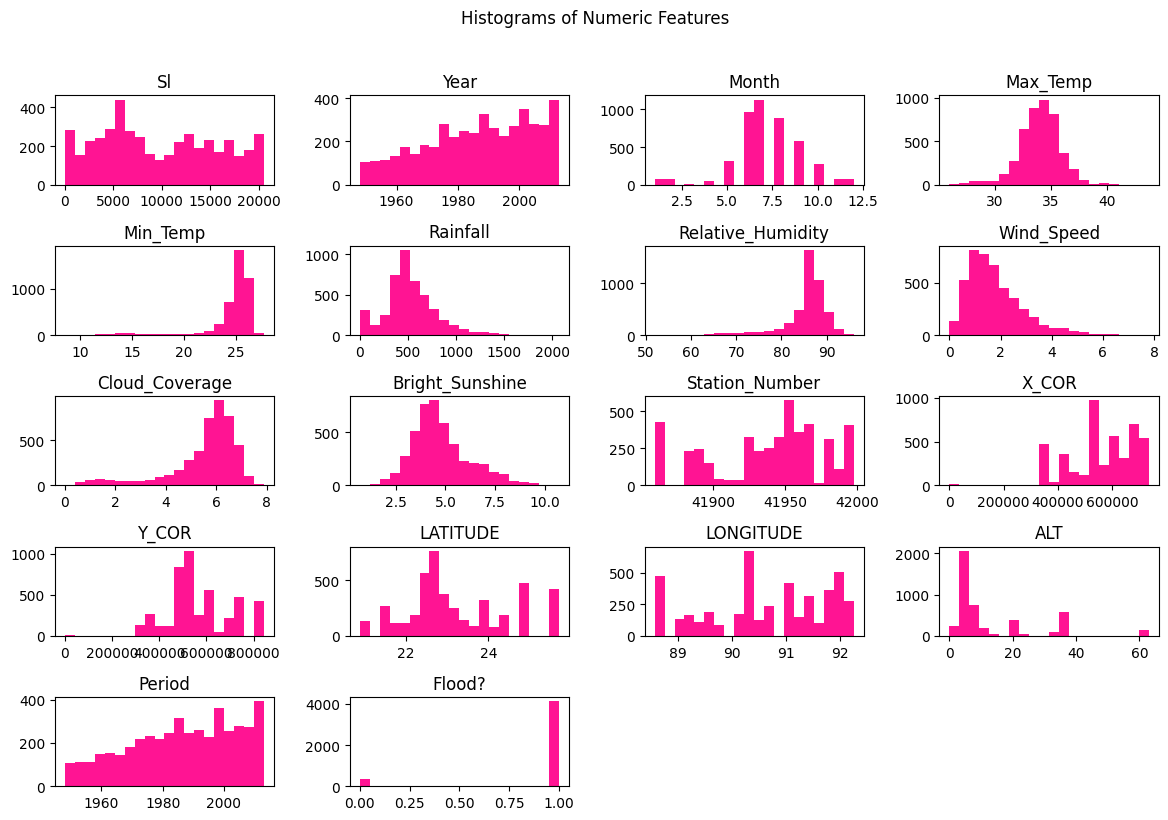

In [9]:
import matplotlib.pyplot as plt

df.select_dtypes(include=['float64', 'int64']).hist(bins=20, color='deeppink', figsize=(12, 8), grid=False)
plt.suptitle('Histograms of Numeric Features', y=1.02)
plt.tight_layout()
plt.show()


In [10]:
print(df.columns.tolist())


['Sl', 'Station_Names', 'Year', 'Month', 'Max_Temp', 'Min_Temp', 'Rainfall', 'Relative_Humidity', 'Wind_Speed', 'Cloud_Coverage', 'Bright_Sunshine', 'Station_Number', 'X_COR', 'Y_COR', 'LATITUDE', 'LONGITUDE', 'ALT', 'Period', 'Flood?']


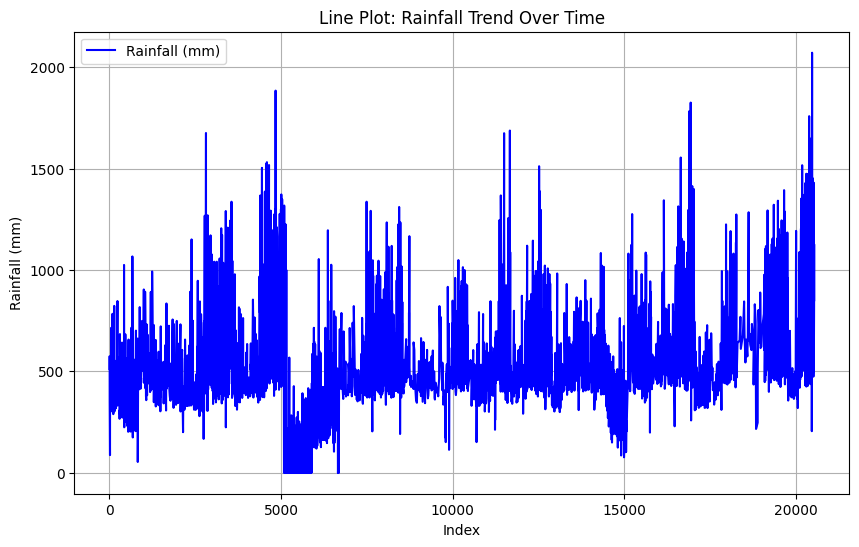

In [11]:
# LINE PLOT: Rainfall Trend Over Index
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Rainfall'], color='blue', label='Rainfall (mm)')
plt.title('Line Plot: Rainfall Trend Over Time')
plt.xlabel('Index')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Define the target variable
y = df.loc[:, "Flood?"]

# Define the features by excluding unwanted columns
X = df.drop(labels=["Flood?", "Station_Names", "Sl"], axis=1)


In [13]:
#  6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=42)


In [14]:
# 7. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
#  8. Train Linear Regression Model
start_time = time.time()
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_time = time.time() - start_time

In [16]:
#  9. Evaluate Linear Regression
lr_preds = lr_model.predict(X_test_scaled)
lr_r2 = r2_score(y_test, lr_preds)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_mae = mean_absolute_error(y_test, lr_preds)

In [17]:
print("\n Linear Regression Results:")
print(f"Training time: {lr_time:.4f} seconds")
print(f"R² Score: {lr_r2:.3f}")
print(f"RMSE: {lr_rmse:.3f}")
print(f"MAE: {lr_mae:.3f}")


 Linear Regression Results:
Training time: 0.0726 seconds
R² Score: 0.744
RMSE: 0.158
MAE: 0.089


In [18]:
# 10. Train Random Forest Regressor (Parallel)
start_time = time.time()
rf_model = RandomForestRegressor(n_estimators=20, max_depth=20, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)
rf_time = time.time() - start_time


In [19]:
import time
from sklearn.ensemble import RandomForestRegressor

# 10. Fit Random Forest Regressor with parallel processing
training_start = time.time()

random_forest = RandomForestRegressor(
    n_estimators=20,
    max_depth=20,
    n_jobs=-1,
    random_state=42
)

random_forest.fit(X_train, y_train)

training_duration = time.time() - training_start


In [20]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# 11. Assess performance of Random Forest model
predictions = random_forest.predict(X_test)

r2_val = r2_score(y_test, predictions)
mse_val = mean_squared_error(y_test, predictions)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_test, predictions)


In [21]:
# Generate predictions using the correct model variable name
rf_preds = random_forest.predict(X_test)

# Calculate metrics
rf_r2 = r2_score(y_test, rf_preds)
rf_mse = mean_squared_error(y_test, rf_preds)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_preds)


In [22]:
import time
from sklearn.ensemble import RandomForestRegressor

# 10. Train Random Forest Regressor
start_time = time.time()

rf_model = RandomForestRegressor(
    n_estimators=20,
    max_depth=20,
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train, y_train)

rf_time = time.time() - start_time


In [23]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

rf_preds = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_preds)
rf_mse = mean_squared_error(y_test, rf_preds)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_preds)


In [24]:
print("\n🔸 Random Forest Regressor Results (Parallel):")
print(f"Training time: {rf_time:.4f} seconds")
print(f"R² Score: {rf_r2:.3f}")
print(f"RMSE: {rf_rmse:.3f}")
print(f"MAE: {rf_mae:.3f}")


🔸 Random Forest Regressor Results (Parallel):
Training time: 0.1435 seconds
R² Score: 0.857
RMSE: 0.118
MAE: 0.020


In [25]:
# 12. Prepare data for XGBoost (CPU & GPU)
from xgboost import DMatrix

train_data = DMatrix(data=X_train, label=y_train)
test_data = DMatrix(data=X_test, label=y_test)


In [26]:
# --- Train XGBoost on CPU ---
from xgboost import XGBRegressor

cpu_model = XGBRegressor(tree_method='hist', predictor='auto', n_jobs=-1, verbosity=0)
start_cpu = time.time()
cpu_model.fit(X_train, y_train)
cpu_time = time.time() - start_cpu

cpu_preds = cpu_model.predict(X_test)
cpu_mse = mean_squared_error(y_test, cpu_preds)
cpu_r2 = r2_score(y_test, cpu_preds)


In [27]:
rf_time = rf_time if 'rf_time' in globals() else None
cpu_time = cpu_time if 'cpu_time' in globals() else None
gpu_time = gpu_time if 'gpu_time' in globals() else None

rf_mse = rf_mse if 'rf_mse' in globals() else None
cpu_mse = cpu_mse if 'cpu_mse' in globals() else None
gpu_mse = gpu_mse if 'gpu_mse' in globals() else None

rf_r2 = rf_r2 if 'rf_r2' in globals() else None
cpu_r2 = cpu_r2 if 'cpu_r2' in globals() else None
gpu_r2 = gpu_r2 if 'gpu_r2' in globals() else None



In [28]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time
import numpy as np

# Make sure your data is in numpy array format
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)

try:
    gpu_model = XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', n_jobs=-1, verbosity=0)
    start_gpu = time.time()
    gpu_model.fit(X_train_np, y_train_np)
    gpu_time = time.time() - start_gpu

    gpu_preds = gpu_model.predict(X_test_np)
    gpu_mse = mean_squared_error(y_test_np, gpu_preds)
    gpu_r2 = r2_score(y_test_np, gpu_preds)

    print(f"GPU training done in {gpu_time:.2f} seconds with R2: {gpu_r2:.4f}")
except Exception as e:
    print("GPU training failed:", e)
    gpu_time, gpu_mse, gpu_r2 = None, None, None


GPU training done in 0.84 seconds with R2: 0.9774


In [29]:
print(f"gpu_time = {gpu_time}")
print(f"gpu_mse = {gpu_mse}")
print(f"gpu_r2 = {gpu_r2}")


gpu_time = 0.8403496742248535
gpu_mse = 0.002216707033901564
gpu_r2 = 0.9773574358130586


In [30]:
comparison_table = {
    "Model": ["Random Forest", "XGBoost (CPU)", "XGBoost (GPU)"],
    "Parallelism": ["CPU (n_jobs=-1)", "CPU (nthread=-1)", "GPU"],
    "Training Time (s)": [
        round(rf_time, 4),
        round(cpu_time, 4),
        round(gpu_time, 4) if gpu_time is not None else 'N/A'
    ],
    "MSE": [
        round(rf_mse, 5),
        round(cpu_mse, 5),
        round(gpu_mse, 5) if gpu_mse is not None else 'N/A'
    ],
    "R2 Score": [
        round(rf_r2, 5),
        round(cpu_r2, 5),
        round(gpu_r2, 5) if gpu_r2 is not None else 'N/A'
    ]
}

results_df = pd.DataFrame(comparison_table)
print("\nModel Performance Summary:")
print(results_df)



Model Performance Summary:
           Model       Parallelism  Training Time (s)      MSE  R2 Score
0  Random Forest   CPU (n_jobs=-1)             0.1435  0.01397   0.85725
1  XGBoost (CPU)  CPU (nthread=-1)             0.5231  0.00222   0.97736
2  XGBoost (GPU)               GPU             0.8403  0.00222   0.97736


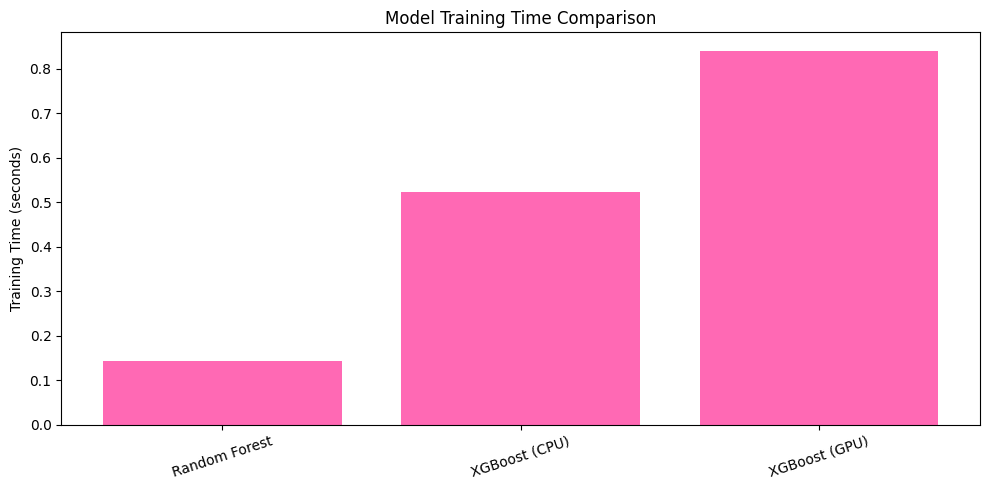

In [31]:
plt.figure(figsize=(10, 5))
plt.bar(results_df["Model"], results_df["Training Time (s)"], color='hotpink')
plt.ylabel("Training Time (seconds)")
plt.title("Model Training Time Comparison")
plt.xticks(rotation=18)
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

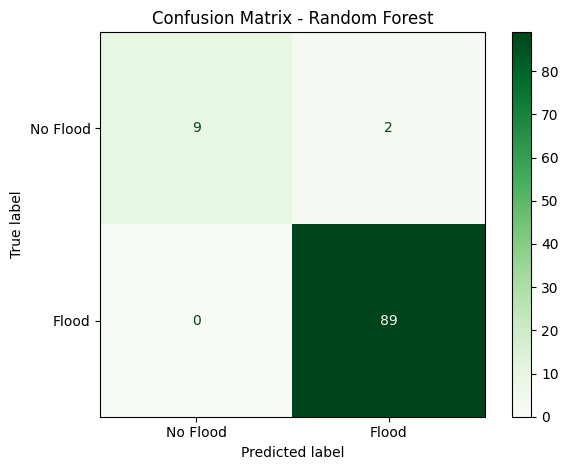

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert predictions to binary class
rf_preds_class = (rf_preds >= 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, rf_preds_class)

# Plot confusion matrix with sage green colormap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Flood", "Flood"])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Greens, values_format='d')  # Using built-in Greens colormap (close to sage green)
plt.title("Confusion Matrix - Random Forest")
plt.grid(False)
plt.tight_layout()
plt.show()


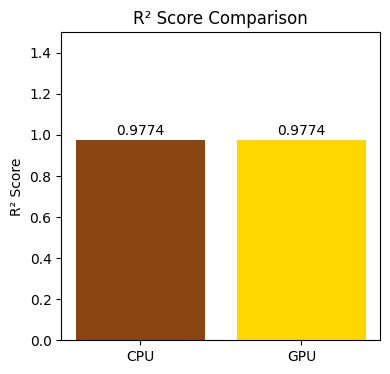

In [33]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.bar(['CPU', 'GPU'], [cpu_r2, gpu_r2], color=['saddlebrown', 'gold'])
plt.title('R² Score Comparison')
plt.ylabel('R² Score')
plt.ylim(0, 1.5)

for i, v in enumerate([cpu_r2, gpu_r2]):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom')
